All edges: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


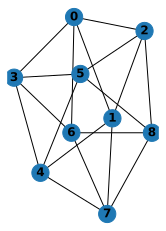

In [1]:
%config InlineBackend.figure_formats = ['svg']
import warnings
warnings.filterwarnings('ignore')
import quimb as qu
import quimb.tensor as qtn
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import math
import gc
from numpy.linalg import eig
#import cotengra as ctg
from skopt import Optimizer
from skopt.plots import plot_convergence, plot_objective


# opt = ctg.ReusableHyperOptimizer(
#     reconf_opts={},
#     max_repeats=16,
#     parallel=True,
#     # use the following for persistently cached paths
#     directory='ctg_path_cache',
# )



dim = 3
#GG = [-1,-0.8,0.8,1]
#JJ = [1]

terms = {}
qub = 0
for i in range(dim):
    for j in range(dim):
        if (j + 1) < dim:
            terms[(qub,qub+1)] = -1

        elif (j+1) == dim: #left
            terms[(qub,qub-(dim-1))] = -1

        if (i + 1) < dim:
            terms[(qub,qub+dim)] = -1

        elif (i+1) == dim: #bottom 
            terms[(qub, qub-(dim*(dim-1)))] = -1
        qub = qub + 1
print("All edges:",list(terms.values()))

#G = nx.grid_2d_graph(dim, dim)
G = nx.Graph()
G.add_edges_from(list(terms.keys())) 
pos = nx.spring_layout(G, k=0.1/math.sqrt(G.order()), iterations=100)

plt.subplot(122)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()


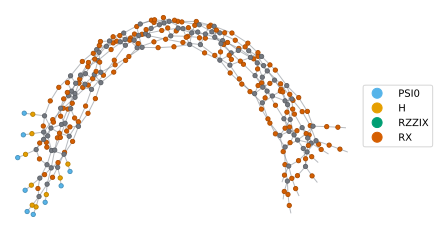

In [2]:
p = 6
#GG = [-1,-0.8,0.8,1]
#JJ = [1]
jj = 1
gg = 1
gammas = qu.randn(p) #change
betas = qu.randn(p) #change
circ_ex = qtn.circ_qaoa(terms, p, gammas, betas,jj,gg)
circ_ex.psi.draw(color=['PSI0', 'H', 'RZZIX', 'RX'])
#circ_ex.get_rdm_lightcone_simplified([0]).draw(color=['PSI0', 'H', 'RZZ', 'RX'], highlight_inds=['k0', 'b0'])

# rehearse
# localHam = -(jj*(qu.pauli('Z') & qu.pauli('Z'))) - (gg*jj* qu.pauli('I') & (qu.pauli('X')))
    
# local_exp_rehs = [
#     circ_ex.local_expectation_rehearse(weight * localHam, edge)
#     for edge, weight in tqdm.tqdm(list(terms.items()))
# ]

In [ ]:
GG = [1]#0.8,-0.8,-1]
JJ = [1]
graphX = []
graphY = []

def addEdge(H,h,a,b):
    N = int(math.pow(2,dim*dim))
    for j in range(N):
        w = '{0:0'+str(dim*dim)+'b}'
        s = w.format(j)
        t = list(s)
        l = (2*int(s[a])) + int(s[b])
        
        for m in range(4):
            t[a] = str(int(m//2))
            t[b] = str(int(m%2))
            y = ''.join(t)
            k = int(y,2)
            #print(j,k,y,l,m)
            H[j][k] = H[j][k] + h[l][m]
            
def getOPT(setJ,setG):
    minEigen = 0.0
    localham = [[-setJ, -setG*setJ,0, 0], 
             [-setG*setJ, setJ, 0, 0],
             [0, 0, setJ, -setG*setJ],
             [0, 0, -setG*setJ, -setJ]]
    d = dim*dim
    N = int(math.pow(2,d))
    Ham = [[0 for l in range(N)] for m in range(N)]
    qub = 0
    
    #addEdge(Ham,localham,0,1)
#     for i in range(d):
#         if(i == (d-1)):
#             addEdge(Ham,localham,i,0)
#         else:
#             addEdge(Ham,localham,i,i+1)
    for i in range(dim):
        for j in range(dim):
                if (j + 1) < dim:
                    addEdge(Ham,localham,qub,qub+1)

                elif (j+1) == dim: #left
                    addEdge(Ham,localham,qub,qub-(dim-1))

                if (i + 1) < dim:
                    addEdge(Ham,localham,qub,qub+dim)

                elif (i+1) == dim: #bottom 
                    addEdge(Ham,localham,qub, qub-(dim*(dim-1)))
                qub = qub + 1
    values , vectors = eig(np.array(Ham))
    minEigen = min(values)
    return minEigen, Ham, vectors

#@functools.lru_cache(maxsize = 2048)
def energy(x,jj,gg):
    #print("got here")
    p = 6 #len(x) // 2
    gammas = x[:p]
    betas = x[p:]
    #print(gammas,betas)
    circ = qtn.circ_qaoa(terms, p, gammas, betas,jj,gg)
    localHam = -(jj*(qu.pauli('Z') & qu.pauli('Z'))) - (gg*jj* qu.pauli('I') & (qu.pauli('X')))
    
    #if(gg>0):
    localEnergies = [
        circ.local_expectation(-weight * localHam, edge)
        for edge, weight in terms.items()
        ]
#     else
#          localEnergies = [
#             circ.local_expectation(weight * localHam, edge)
#             for edge, weight in terms.items()
#         ]

    return sum(localEnergies).real

# print(energy(2))
results = {}
def main(jj,gg,e):
#     goodAngles = [[math.radians(90.22110513906951), math.radians(0.0),
#                    math.radians(176.51383390184128),math.radians(141.11825420982152)],
#                  [math.radians(5.404668437470206), math.radians(157.65216329079215)
#                   ,math.radians(0),math.radians(0)],
#                  [math.radians(2.2589862450668434), math.radians(101.72111159117486)
#                   ,math.radians(0),math.radians(0)],
#                  [math.radians(3.536435831364359), math.radians(15.789967085395785)
#                   ,math.radians(0),math.radians(0)]]
    #gg = 0
    eps = 1e-6 # ?
    bounds = (
        [(0.0  , qu.pi )] * p +
        [(0.0  , (qu.pi))] * p
    )
    #print(qu.pi)
    bopt = Optimizer(bounds)
    trueOpt, Ham, eigBasis = getOPT(jj,gg)
    count = 0
    for i in tqdm.trange(800):
        angles = bopt.ask()
#         if count == 0:
#             angles = goodAngles[e]
#             count = 1
        
        results = bopt.tell(angles, energy(tuple(angles),jj,gg))
        #energy.cache_clear()

    print("angles",[math.degrees(i) for i in results.x])
    print("Results for g/j = "+str(gg/jj)+" at P = "+str(p))
    print("True opt = ",trueOpt)
    print("Tensor opt = ",results.fun)
    plot_convergence(results);
    graphY.append(results.fun/trueOpt)
    graphX.append(gg/jj)

if __name__ == '__main__':
    for l in range(len(JJ)):
        for m in range(len(GG)):
            main(JJ[l],GG[m],m)
            
# plt.plot(graphX,graphY, 'go')
# plt.ylabel('opt ratio = λ*/min λ')
# plt.xlabel('g/J')
# plt.axis([int((min(GG)/max(JJ))-1), int((max(GG)/min(JJ))+1),0,1])
# plt.title('Finding Ground states of the TIMm using a Tensor Net and grid d = '+str(dim)+' and Parameters = '+str(p*2))
# plt.show()
        

  0%|          | 0/800 [00:00<?, ?it/s]